In [2]:
import os
import shap
import xgboost
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

from src.utils import get_project_root
from src.data.make_dataset import load_dataset
from src.features.build_features import MetadataTransformer,CalendarTransformer, HolidaysTransformer, fill_time_series
from sklearn.pipeline import Pipeline
from src.evaluation.scoring import wmape, wbias
from src.data.splitting import split_dataset, time_series_cv

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
dataset = load_dataset()
dataset = dataset.set_index('sales_date')

Dataframe shape:  (38338, 10)
Time (s):  0.5415630340576172
2013 done.
Dataframe shape:  (40317, 10)
Time (s):  0.4118993282318115
2014 done.
Dataframe shape:  (42351, 10)
Time (s):  0.4151911735534668
2015 done.
Dataframe shape:  (55354, 10)
Time (s):  0.6620244979858398
2016 done.
Dataframe shape:  (64267, 10)
Time (s):  0.5880310535430908
2017 done.
Dataframe shape:  (65991, 10)
Time (s):  0.6374120712280273
2018 done.
Dataframe shape:  (72220, 10)
Time (s):  0.8108441829681396
2019 done.
Dataframe shape:  (43087, 10)
Time (s):  0.5403258800506592
2020 done.
  item_name                sales_date  sales_qty  item_price  sales_value
0     Amaro 2013-03-07 00:00:00+00:00          1         9.0          9.0
1     Amaro 2013-04-14 00:00:00+00:00          1         9.0          9.0
2     Amaro 2013-07-23 00:00:00+00:00          1         9.0          9.0
3     Amaro 2013-07-24 00:00:00+00:00          1         9.0          9.0
4     Amaro 2013-08-11 00:00:00+00:00          1         9.0  

In [149]:
dataset.item_name.unique()

array(['Amaro', 'Apelino', 'Bacardi', 'Ballantine`s', 'Batida de coco',
       'Beck`s', 'Becks', 'Becks 0.33', 'Bijela kava', 'Blue Moon',
       'Borovnica', 'Brandy', 'Budweiser', 'Budwieser', 'Campari',
       'Cappuccino', 'Captain Morgan', 'Carling Cider', 'Carolans',
       'Cedevita', 'Cherry brandy', 'Chivas', 'Coca Cola', 'Coca-Cola',
       'Cockta', 'Corona', 'Crvena orangina', 'Dodatak', 'Emotion',
       'Fanta', 'Franciscan Well', 'Franziskaner', 'Frappe',
       'Gin  0,03 10,00', 'Gin Tanqueray', 'Heineken', 'Hennessy',
       'Jack Daniels', 'Jagermeister', 'Jamnica ginger',
       'Jamnica sensation', 'Jana vitaminski napitak', 'Johnnie Walker',
       'Juicy', 'Kakao', 'Kaltenberg', 'Karlovaèko Hajduk',
       'Karlovaèko Radler', 'Karlovaèko pivo', 'Karlovaèko radler',
       'Kava', 'Kava bez kof. s mlij.', 'Kava bez kof. sa \x9alagom',
       'Kava bez kofeina', 'Kava mix', 'Kava s mlijekom',
       'Kava s mlijekom velika', 'Kava s mljekom i \x9alagom velika',
 

In [4]:
dataset_summary = dataset.reset_index().groupby('item_name').agg({'sales_qty': ['sum', 'count'],
                                                   'sales_date': ['min', 'max']}).reset_index()
dataset_summary.columns = ['item_name', 'sales_per_item', 'days_of_sales', 'min_date', 'max_date']
## Calculate sales ratio and cumulative sum of sales
dataset_summary.loc[:, 'total_sales'] = dataset_summary.sales_per_item.sum()
dataset_summary.loc[:, 'sales_ratio'] = dataset_summary['sales_per_item']/dataset_summary['total_sales']
dataset_summary = dataset_summary.sort_values(by='sales_per_item', ascending=False)
dataset_summary.loc[:, 'sales_ratio_cumsum'] = dataset_summary['sales_ratio'].cumsum()
dataset_summary.head(10)

,item_name,sales_per_item,days_of_sales,min_date,max_date,total_sales,sales_ratio,sales_ratio_cumsum
56,Kava s mlijekom velika,142880,2807,2013-01-28 00:00:00+00:00,2020-11-27 00:00:00+00:00,509664,0.280342,0.280342
50,Kava,41661,2807,2013-01-28 00:00:00+00:00,2020-11-27 00:00:00+00:00,509664,0.081742,0.362084
19,Cedevita,31950,2775,2013-01-28 00:00:00+00:00,2020-11-27 00:00:00+00:00,509664,0.062688,0.424772
77,Nescaffe,30880,2795,2013-01-28 00:00:00+00:00,2020-11-27 00:00:00+00:00,509664,0.060589,0.485361
55,Kava s mlijekom,30343,2796,2013-01-28 00:00:00+00:00,2020-11-27 00:00:00+00:00,509664,0.059535,0.544896
22,Coca Cola,14692,2678,2013-01-29 00:00:00+00:00,2020-11-27 00:00:00+00:00,509664,0.028827,0.573723
136,Èaj,14402,1642,2013-01-28 00:00:00+00:00,2020-11-27 00:00:00+00:00,509664,0.028258,0.601981
12,Budweiser,12362,2185,2014-01-09 00:00:00+00:00,2020-11-27 00:00:00+00:00,509664,0.024255,0.626236
40,Jamnica sensation,11849,2543,2013-01-28 00:00:00+00:00,2020-11-22 00:00:00+00:00,509664,0.023249,0.649485
75,Mineralna voda,10907,2606,2013-01-28 00:00:00+00:00,2020-11-27 00:00:00+00:00,509664,0.021400,0.670885


In [123]:
## Filter dataset to include only items with a big share in sales
filtered_dataset = dataset[dataset.item_name.isin(dataset_summary[:40].item_name.tolist())]

## Fill days with no sales ##
dataset_filled = filtered_dataset.groupby('item_name').apply(fill_time_series).drop(columns=['item_name']).reset_index().set_index('sales_date')

## 

<Axes: xlabel='sales_date'>

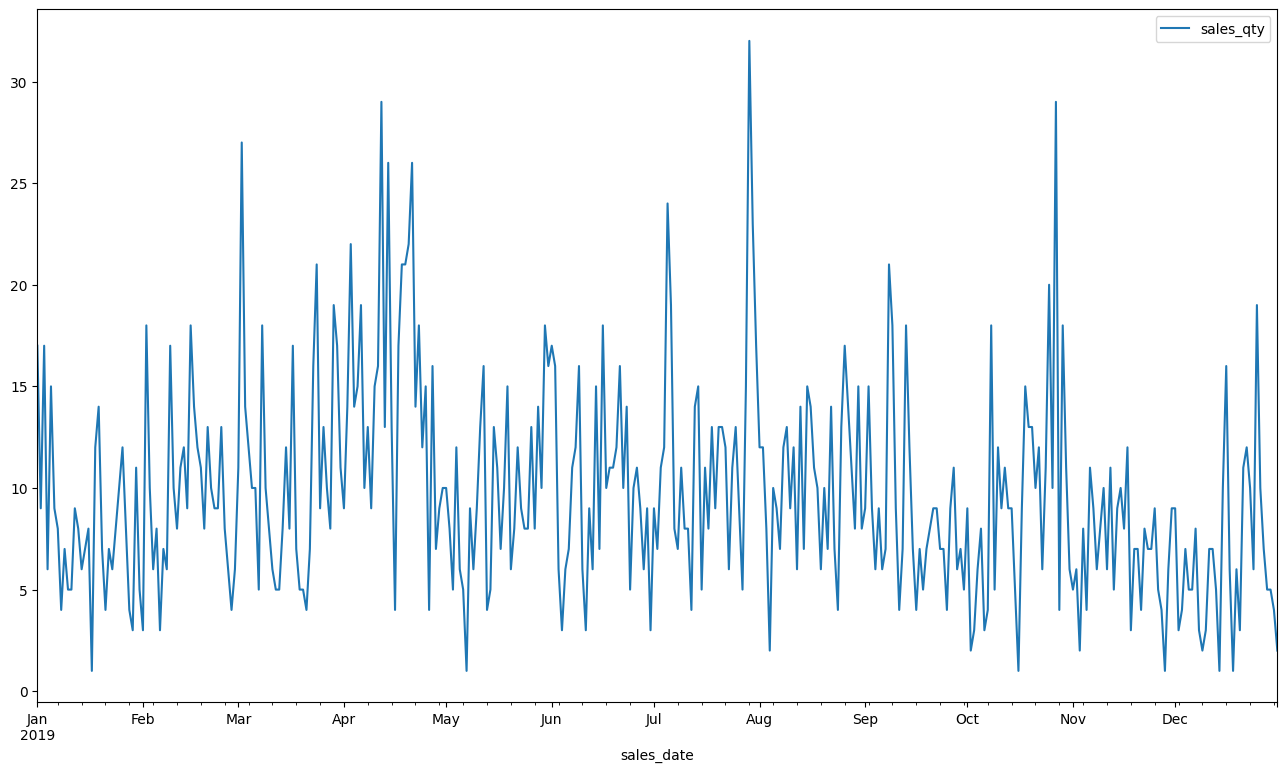

In [124]:
dataset_filled[(dataset_filled.item_name == 'Coca Cola') & (dataset_filled.index.year == 2019)].plot(y='sales_qty', figsize=(16,9))

# Inventory simulation function
- substract inventory by sales each day until you get to zero or below, then set starting inventory value again and repeat

In [126]:
# Example
cola_data = dataset_filled[(dataset_filled.item_name == 'Coca Cola') & (dataset_filled.index.year == 2019)].copy().sort_index()

starting_stock = 100 # last year max approx
stock_eod = 100
stock_end_of_day = []
for val in cola_data['sales_qty'].values:
    if len(stock_end_of_day) == 0:
        stock_eod = starting_stock - val
    elif stock_eod <= 0:
        stock_eod += starting_stock
    else:
        stock_eod -= val
    if stock_eod < 0:
        stock_end_of_day.append(0)
    else:
        stock_end_of_day.append(stock_eod)

In [127]:
# Function for applying to df
def inventory_simulation(sales_df: pd.DataFrame, 
                         sales_col: str, 
                         start_stock_col: str):
    stock_end_of_day = []
    for sale, start_stock in sales_df[[sales_col, start_stock_col]].values:
        if len(stock_end_of_day) == 0:
            stock_eod = start_stock - sale
        elif stock_eod <= 0:
            stock_eod += start_stock
        else:
            stock_eod -= sale
        if stock_eod < 0:
            stock_end_of_day.append(0)
        else:
            stock_end_of_day.append(stock_eod)
    sales_df['inventory'] = stock_end_of_day    
    return sales_df

In [128]:
# yearly_max_sales = dataset_filled.groupby(['item_name', dataset_filled.index.year])['sales_qty'].max().reset_index()
# previous_year_max_sales = yearly_max_sales.copy()
# previous_year_max_sales['sales_date'] += 1
# previous_year_max_sales = previous_year_max_sales.rename(columns={'sales_date': 'sales_year', 'sales_qty': 'max_sales_qty'})

# dataset_filled['sales_year'] = dataset_filled.index.year
# dataset_filled = dataset_filled.reset_index().merge(previous_year_max_sales, 
#                      how='left', 
#                      on=['item_name', 'sales_year']).set_index('sales_date')

# dataset_filled['max_sales_qty'] = dataset_filled.groupby('item_name')['max_sales_qty'].fillna(method='backfill')
# dataset_filled['max_sales_qty_x2'] = dataset_filled['max_sales_qty']*2
# dataset_filled = dataset_filled.groupby('item_name').apply(lambda x: inventory_simulation(x, 'sales_qty', 'max_sales_qty_x2')).drop(columns=['item_name']).reset_index(level='item_name')
# dataset_filled[(dataset_filled.item_name == 'Beck`s') & (dataset_filled.index.year == 2019)].plot(y=['sales_qty', 'inventory'], figsize=(18, 6))

In [129]:
dataset_filled[(dataset_filled.item_name == 'Beck`s') & (dataset_filled.index.year == 2019)][:20]

,item_name,sales_qty,item_price,sales_value
sales_date,,,,
2019-01-01 00:00:00+00:00,Beck`s,0,18.0,0.0
2019-01-02 00:00:00+00:00,Beck`s,1,18.0,18.0
2019-01-03 00:00:00+00:00,Beck`s,3,18.0,54.0
2019-01-04 00:00:00+00:00,Beck`s,4,18.0,72.0
2019-01-05 00:00:00+00:00,Beck`s,0,18.0,0.0
2019-01-06 00:00:00+00:00,Beck`s,4,18.0,72.0
2019-01-07 00:00:00+00:00,Beck`s,4,18.0,72.0
2019-01-08 00:00:00+00:00,Beck`s,10,18.0,180.0
2019-01-09 00:00:00+00:00,Beck`s,1,18.0,18.0


# For applying on whole dataset

- for each item starting stock can be set to twice or three times the sales on previous year
- apply inventory_simulation function for whole dataframe

In [130]:
def simulate_inventory(dataset: pd.DataFrame) -> pd.DataFrame:
    yearly_max_sales = dataset.groupby(['item_name', dataset.index.year])['sales_qty'].max().reset_index()
    previous_year_max_sales = yearly_max_sales.copy()
    previous_year_max_sales['sales_date'] += 1
    previous_year_max_sales = previous_year_max_sales.rename(columns={'sales_date': 'sales_year', 'sales_qty': 'max_sales_qty'})
    dataset['sales_year'] = dataset.index.year
    dataset = dataset.reset_index().merge(previous_year_max_sales, 
                                          how='left', 
                                          on=['item_name', 'sales_year']
                                         ).set_index('sales_date')
    dataset['max_sales_qty'] = dataset.groupby('item_name')['max_sales_qty'].fillna(method='backfill')
    dataset['max_sales_qty_x2'] = dataset['max_sales_qty']*2
    dataset = dataset.groupby('item_name').apply(lambda x: inventory_simulation(x, 'sales_qty', 'max_sales_qty_x2')).drop(columns=['item_name']).reset_index(level='item_name')
    return dataset
    

    

In [131]:
dataset_with_inventory = simulate_inventory(dataset_filled)

<Axes: xlabel='sales_date'>

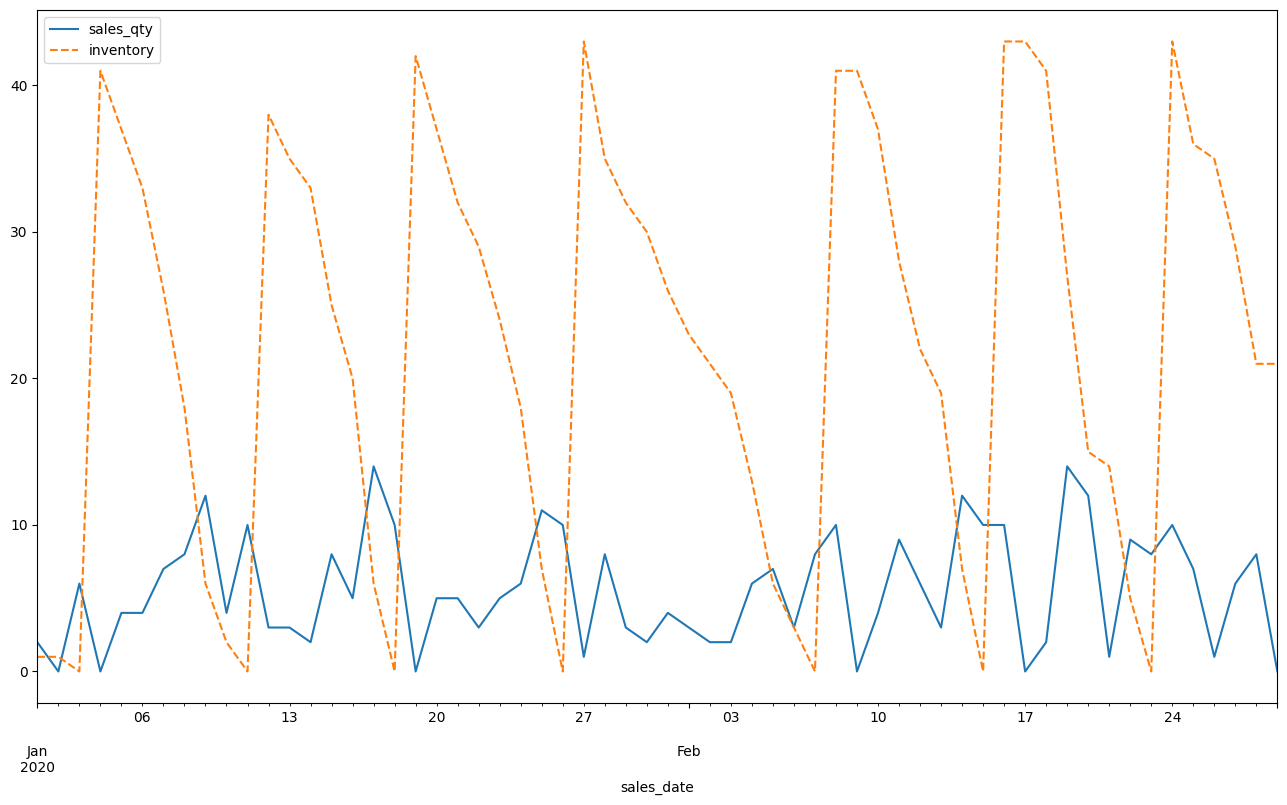

In [143]:
example_plot_df = dataset_with_inventory[
    (dataset_with_inventory.item_name == 'Beck`s') & 
    (dataset_with_inventory.index.year == 2020) & 
    (dataset_with_inventory.index.month.isin([1, 2]))]
example_plot_df.plot(y=['sales_qty', 'inventory'], style=['-', '--'], figsize=(16,9))

In [142]:
example_plot_df[example_plot_df.index.month.isin([2])]

,item_name,sales_qty,item_price,sales_value,sales_year,max_sales_qty,max_sales_qty_x2,inventory
sales_date,,,,,,,,
2019-02-01 00:00:00+00:00,Beck`s,3,18.0,54.0,2019,17.0,34.0,30.0
2019-02-02 00:00:00+00:00,Beck`s,11,18.0,198.0,2019,17.0,34.0,19.0
2019-02-03 00:00:00+00:00,Beck`s,4,18.0,72.0,2019,17.0,34.0,15.0
2019-02-04 00:00:00+00:00,Beck`s,1,18.0,18.0,2019,17.0,34.0,14.0
2019-02-05 00:00:00+00:00,Beck`s,0,18.0,0.0,2019,17.0,34.0,14.0
2019-02-06 00:00:00+00:00,Beck`s,7,18.0,126.0,2019,17.0,34.0,7.0
2019-02-07 00:00:00+00:00,Beck`s,4,18.0,72.0,2019,17.0,34.0,3.0
2019-02-08 00:00:00+00:00,Beck`s,5,18.0,90.0,2019,17.0,34.0,0.0
2019-02-09 00:00:00+00:00,Beck`s,2,18.0,36.0,2019,17.0,34.0,32.0


<Axes: xlabel='sales_date'>

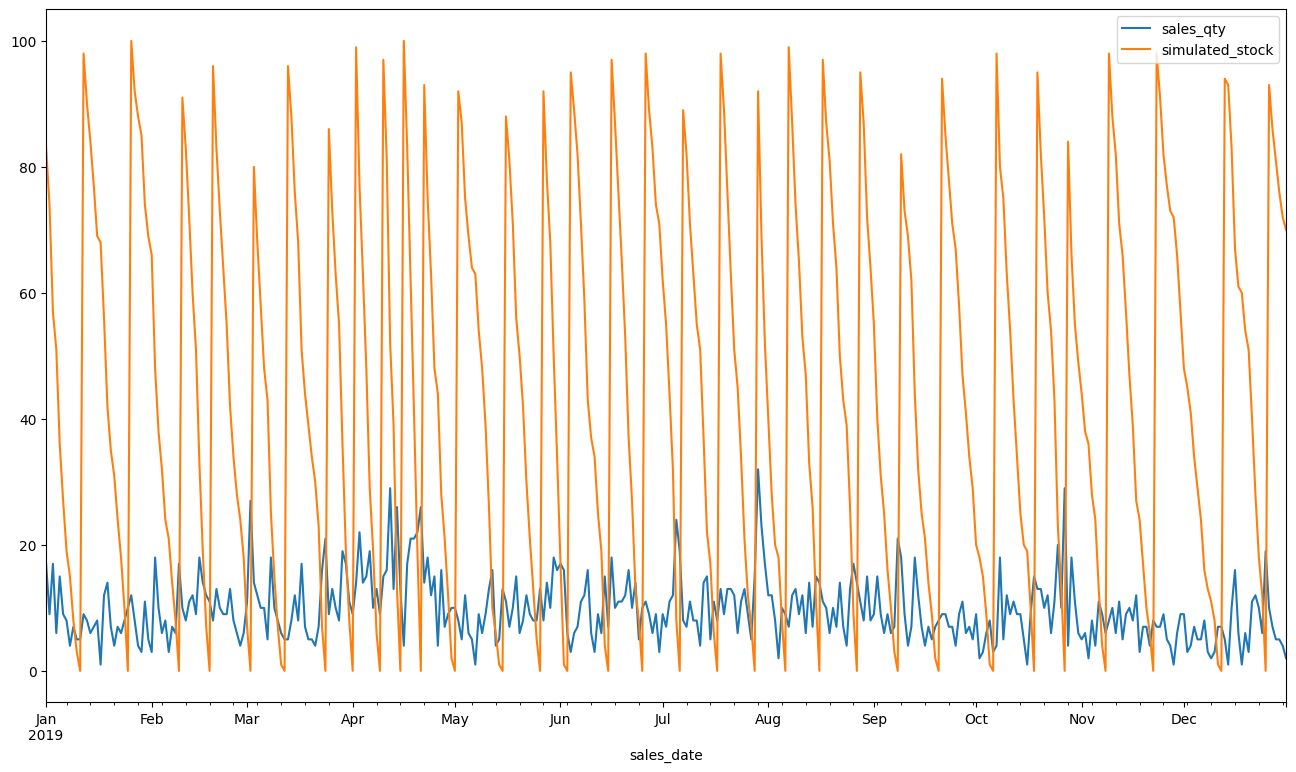

In [49]:
cola_data.plot(y=['sales_qty', 'simulated_stock'], figsize=(16,9))

# Save dataset with inventory

In [146]:
DATASETS_FOLDER = get_project_root() / 'data/processed'
INVENTORY_DATASET_PATH = DATASETS_FOLDER / 'inventory_data_top40.pkl'

In [147]:
dataset_with_inventory.to_pickle(INVENTORY_DATASET_PATH)

In [148]:
dataset_with_inventory.item_name.unique()

array(['Beck`s', 'Bijela kava', 'Budweiser', 'Cappuccino', 'Cedevita',
       'Coca Cola', 'Cockta', 'Emotion', 'Jamnica sensation',
       'Jana vitaminski napitak', 'Juicy', 'Kakao', 'Karlovaèko Hajduk',
       'Karlovaèko pivo', 'Kava', 'Kava s mlijekom',
       'Kava s mlijekom velika', 'Kava sa \x9alagom velika', 'Ledeni Èaj',
       'Limona', 'Mineralna voda', 'Nescaffe', 'Nik\x9aièko', 'Orahovac',
       'O\x9eujsko', 'Pelinkovac', 'Pipi', 'Prirodni sokovi', 'Schweppes',
       'Somersby', 'Spezi+kava', 'Staropramen', 'Stella Artois',
       'Velika kava s \x9alagom', 'Vino  0,2 l', 'Vi\x9anjevaèa', 'Vodka',
       'Zlatni Pan', 'Èaj', 'Èaj s limunom i medom'], dtype=object)